Notebook used in dataset overview.

In [1]:
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from neural.common.data.datasets import DatasetGenerator
from utils.database import DatabaseConnector

In [2]:
save_path = Path('images/datasets')
save_path.mkdir(parents=True, exist_ok=True)
sns.set_theme()
sns.set_palette('muted')

In [3]:
def all_splits(func: Callable[[str], None]) -> Callable[[], None]:
    def wrapper() -> None:
        for split in ['train', 'validation', 'test']:
            func(split)

    return wrapper

In [4]:
def print_entities_examples(dataset_name: str, max_tags: int = 20, skip_sentences: int = 0, entity_type: str = None):
    tags_dict = DatabaseConnector().get_tags_dict(dataset_name)
    dataset = DatasetGenerator.generate_dataset(dataset_name, 'train')
    tags_count = 0
    for i, (sentence, tags) in enumerate(dataset):
        if i < skip_sentences:
            continue
        for j, tag in enumerate(tags):
            if tag in tags_dict and (entity_type is None or tags_dict[tag][1] == entity_type):
                print(sentence[j], tags_dict[tag])
                tags_count += 1

        if tags_count >= max_tags:
            break

In [5]:
@all_splits
def print_ner_dataset_distribution(split: str) -> None:
    detokenizer = TreebankWordDetokenizer()
    article_count = 0
    sentence_count = 0
    tokens_count = 0
    for tokens, tags in DatasetGenerator.generate_dataset('gmb', split):
        article_count += 1
        sentence_count += len(sent_tokenize(detokenizer.detokenize(tokens)))
        tokens_count += len(tokens)
    print(f'Dataset stats for {split} split:')
    print('Article count:', article_count)
    print('Sentence count:', sentence_count)
    print('Tokens count:', tokens_count)

In [6]:
@all_splits
def plot_ner_dataset_lengths(split: str) -> None:
    conll_tokens_lengths = []
    for tokens, tags in DatasetGenerator.generate_dataset('conll2003', split):
        conll_tokens_lengths.append(len(tokens))

    gmb_tokens_lengths = []
    for tokens, tags in DatasetGenerator.generate_dataset('gmb', split):
        gmb_tokens_lengths.append(len(tokens))

    data = {
        'CoNLL-2003': conll_tokens_lengths,
        'GMB': gmb_tokens_lengths
    }

    plt.figure(figsize=(15, 7))
    plt.xlim(0, 170)
    plt.yscale('log')
    plt.xlabel('Data sample length')
    plt.ylabel('Number of samples')
    plt.title(f'Dataset samples length comparison in {split} split.')
    sns.histplot(data, binwidth=2)
    plt.savefig(save_path / f'ner_datasets_lengths_{split}.png')
    plt.show()

In [7]:
print_entities_examples('conll2003')

Reusing dataset conll2003 (C:\Users\Miki\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/14041 [00:00<?, ?it/s]

EU ('B-ORG', 'Organizations')
German ('B-MISC', 'Miscellaneous')
British ('B-MISC', 'Miscellaneous')
Peter ('B-PER', 'Persons')
Blackburn ('I-PER', 'Persons')
BRUSSELS ('B-LOC', 'Locations')
European ('B-ORG', 'Organizations')
Commission ('I-ORG', 'Organizations')
German ('B-MISC', 'Miscellaneous')
British ('B-MISC', 'Miscellaneous')
Germany ('B-LOC', 'Locations')
European ('B-ORG', 'Organizations')
Union ('I-ORG', 'Organizations')
Werner ('B-PER', 'Persons')
Zwingmann ('I-PER', 'Persons')
Britain ('B-LOC', 'Locations')
Commission ('B-ORG', 'Organizations')
Nikolaus ('B-PER', 'Persons')
van ('I-PER', 'Persons')
der ('I-PER', 'Persons')
Pas ('I-PER', 'Persons')


In [8]:
print_entities_examples('gmb')

Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/6646 [00:00<?, ?it/s]

London ('B-GEO', 'Geographical Entities')
Iraq ('B-GEO', 'Geographical Entities')
British ('B-GPE', 'Geopolitical Entities')
Bush ('B-PER', 'Persons')
Hyde ('B-GEO', 'Geographical Entities')
Park ('I-GEO', 'Geographical Entities')
Britain ('B-GEO', 'Geographical Entities')
Labor ('B-ORG', 'Organizations')
Party ('I-ORG', 'Organizations')
English ('B-GPE', 'Geopolitical Entities')
Brighton ('B-GEO', 'Geographical Entities')
Britain ('B-GPE', 'Geopolitical Entities')
Iraq ('B-GEO', 'Geographical Entities')
British ('B-GPE', 'Geopolitical Entities')
London ('B-GEO', 'Geographical Entities')
Rome ('B-GEO', 'Geographical Entities')
Paris ('B-GEO', 'Geographical Entities')
Madrid ('B-GEO', 'Geographical Entities')
International ('B-ORG', 'Organizations')
Atomic ('I-ORG', 'Organizations')
Energy ('I-ORG', 'Organizations')
Agency ('I-ORG', 'Organizations')
Vienna ('B-GEO', 'Geographical Entities')
Wednesday ('B-TIM', 'Time indicator')
Iran ('B-GPE', 'Geopolitical Entities')
Iran ('B-GPE', 'Geo

In [9]:
print_ner_dataset_distribution()

Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/6646 [00:00<?, ?it/s]

Dataset stats for train split:
Article count: 6646
Sentence count: 41404
Tokens count: 893891
Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/1173 [00:00<?, ?it/s]

Dataset stats for validation split:
Article count: 1173
Sentence count: 7267
Tokens count: 158203
Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/1380 [00:00<?, ?it/s]

Dataset stats for test split:
Article count: 1380
Sentence count: 8564
Tokens count: 184844


Reusing dataset conll2003 (C:\Users\Miki\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/14041 [00:00<?, ?it/s]

Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/6646 [00:00<?, ?it/s]

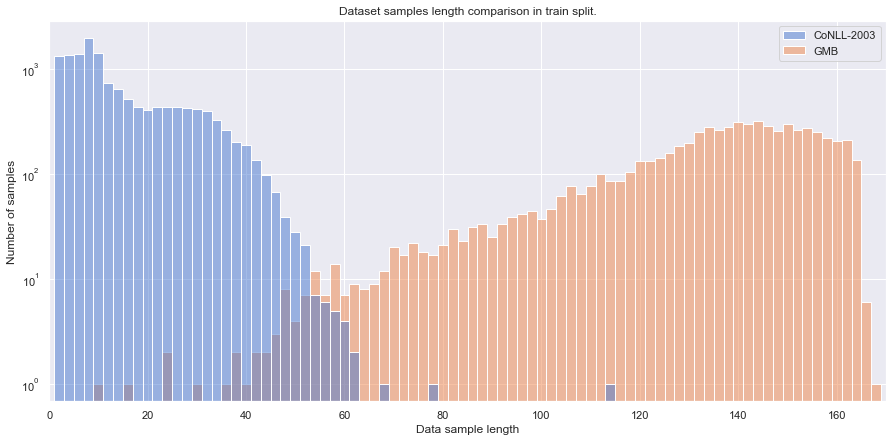

Reusing dataset conll2003 (C:\Users\Miki\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3250 [00:00<?, ?it/s]

Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/1173 [00:00<?, ?it/s]

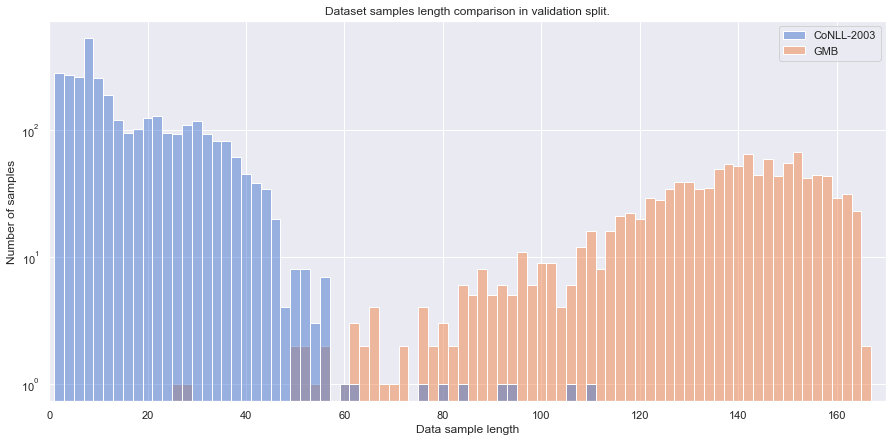

Reusing dataset conll2003 (C:\Users\Miki\.cache\huggingface\datasets\conll2003\conll2003\1.0.0\40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3453 [00:00<?, ?it/s]

Reusing downloaded dataset from C:\Users\Miki\.cache\datasets\gmb_dataset.


  0%|          | 0/1380 [00:00<?, ?it/s]

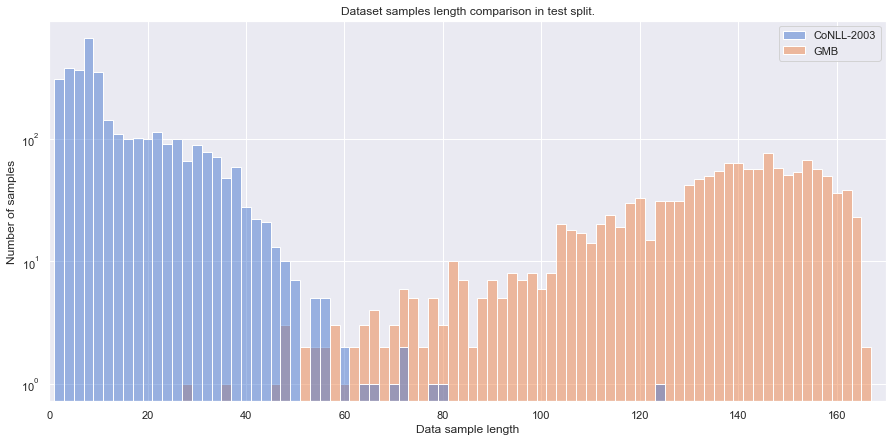

In [10]:
plot_ner_dataset_lengths()